In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import networkx as nx
import osmnx as ox

import multiprocessing as mp

# Computing Network Distance on Boston SafeGraph OD Matrix (walk)

## 1. Loading the Data

### 1.1. Loading the OD matrix

Load the data matrix. This matrix is not available in the repository due to data privacy. Please rename it according to the main README instructions in your local machine.

In [2]:
boston_od_df = pd.read_csv('../data/d00_examples/weeks_od_boston_sample.csv')
boston_od_df

,census_block_group,id,date_range_start,date_range_end,safegraph_place_id,latitude,longitude,intptlon,intptlat,poi_cbg,est_visitor,distance,state,top_category
0,2.500100e+11,207335,9/2/19 05:00,9/9/19 05:00,sg:ce11db7e2fe34ac0929d4f357f517706,41.956274,-70.664559,-70.512049,41.770210,2.502350e+11,106.666667,24239.55247,ma,Restaurants and Other Eating Places
1,2.500100e+11,456782,9/9/19 05:00,9/16/19 05:00,sg:c449cc9f5cd445deadf02bfe03396b2a,42.236044,-70.768497,-70.512049,41.770210,2.502350e+11,81.920000,55965.14288,ma,Other Amusement and Recreation Industries
2,2.500100e+11,748211,9/16/19 05:00,9/23/19 05:00,sg:e8e7e9f5204f45cb8d1ab353a94f1b4a,41.788276,-70.750110,-70.512049,41.770210,2.502350e+11,110.702703,19841.97195,ma,Gasoline Stations
3,2.500100e+11,539378,9/16/19 05:00,9/23/19 05:00,sg:1795a3a508eb4b599c080c0b7114aa7c,42.080822,-70.937099,-70.512049,41.770210,2.502350e+11,110.702703,49289.45174,ma,Restaurants and Other Eating Places
4,2.500100e+11,986779,9/23/19 05:00,9/30/19 05:00,sg:e30a618073494f5a847a48cb982e8fd3,41.954507,-70.714388,-70.512049,41.770210,2.502350e+11,102.400000,26471.27337,ma,Restaurants and Other Eating Places
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2.500100e+11,106321,9/2/19 05:00,9/9/19 05:00,sg:63e9fd5cda7648d9abf29c60f323866d,41.897718,-70.951001,-70.489784,41.760315,2.502350e+11,73.230769,41155.49921,ma,Restaurants and Other Eating Places
96,2.500100e+11,747550,9/16/19 05:00,9/23/19 05:00,sg:e807cf3461444a5e954342a34c46a1ec,41.758087,-70.666694,-70.489784,41.760315,2.502350e+11,86.545455,14676.09350,ma,Other Amusement and Recreation Industries
97,2.500100e+11,757369,9/16/19 05:00,9/23/19 05:00,sg:f21a9d43500c4b12bc195b77caa997ce,41.930511,-70.657772,-70.489784,41.760315,2.502350e+11,86.545455,23490.14658,ma,Restaurants and Other Eating Places
98,2.500100e+11,451727,9/9/19 05:00,9/16/19 05:00,sg:bf0b9719047e449bbcbfa8d79e135dc9,41.758129,-70.660567,-70.489784,41.760315,2.502350e+11,75.157895,14167.87299,ma,Restaurants and Other Eating Places


Seems like we need to fix the census block group. Saving the file as a csv may have rounded it so that the BG geoids are not reliable anymore. Notice how there is only one block group as origin yet a few centroid longitudes, which is incoherent:

In [3]:
print('Unique origin census block groups GEOIDs:', set(boston_od_df['census_block_group'].values))
print('Unique origin census block groups longitudes:', set(boston_od_df['intptlon'].values))

Unique origin census block groups GEOIDs: {250010000000.0}
Unique origin census block groups longitudes: {-70.5006834, -70.5120492, -70.4897837}


To ignore this issue, the analysis will be performed only considering the pre-computed latitude and longitude values.

### 1.2. Loading the Boundary

In [4]:
us_ufa_gdf = gpd.read_file('../data/d01_raw/FUA shapefiles/USA_core_commuting.shx')
boston_bdry_gdf = us_ufa_gdf.loc[us_ufa_gdf['fuaname'] == 'Boston'].reset_index()

### 1.3. Loading the Street Network

For the networks, there is some deprecation warnings from OSMnx, which is OK:

In [8]:
boston_walk_graph = ox.graph_from_polygon(boston_bdry_gdf['geometry'][0], network_type='walk')
#boston_walk_graph_proj = ox.project_graph(boston_walk_graph)
#boston_drive_graph = ox.graph_from_polygon(boston_bdry_gdf['geometry'][0], network_type='drive')

/Users/gsagostini/opt/anaconda3/envs/amenities-distance/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/gsagostini/opt/anaconda3/envs/amenities-distance/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/gsagostini/opt/anaconda3/envs/amenities-distance/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


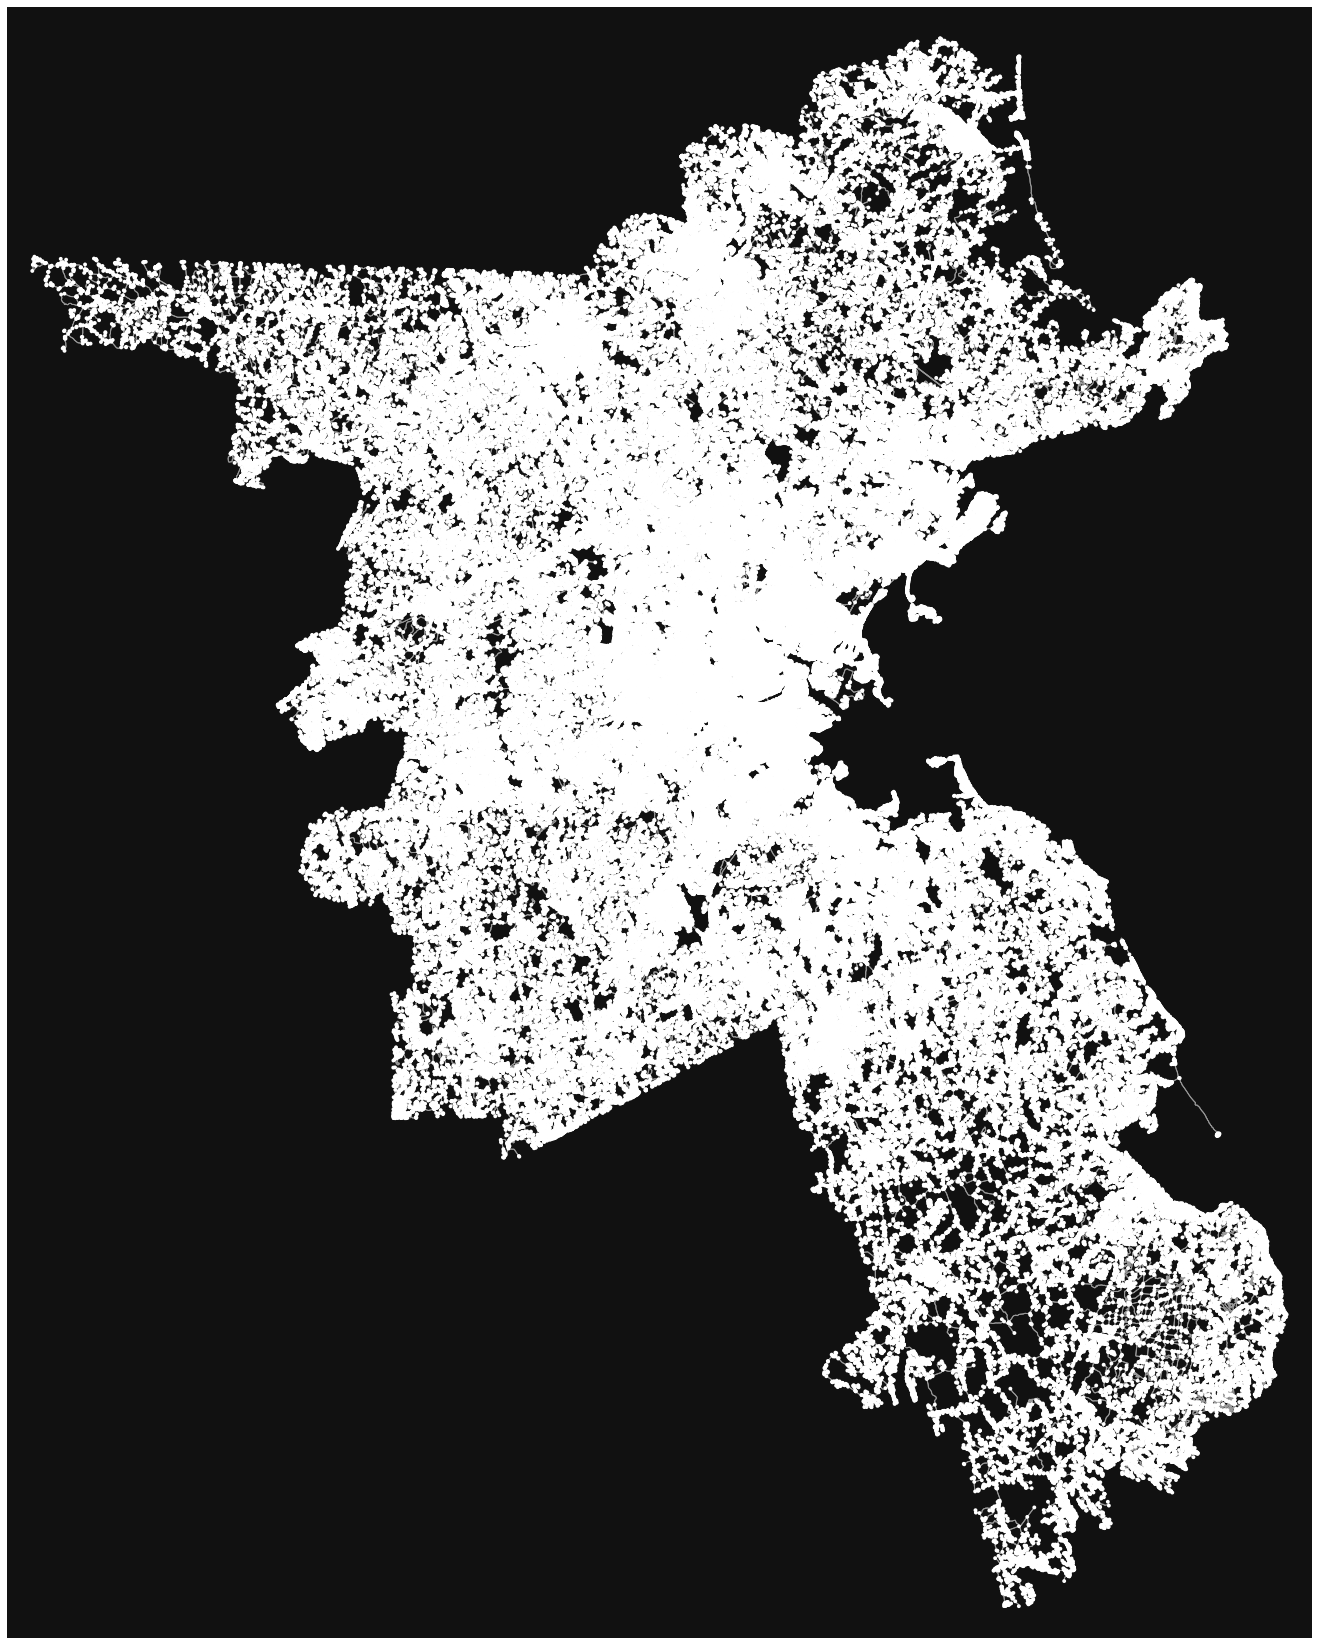

(<Figure size 2160x2160 with 1 Axes>, <AxesSubplot:>)

In [9]:
ox.plot_graph(boston_walk_graph, figsize=(30,30))

For this test run, we focus ONLY on the walking network

## 2. Getting closest nodes

Now that we have our OD matrix, we must match the OD coordinates to nodes in the graphs. For that, we can do:

In [34]:
boston_od_df['origin_osmid'], boston_od_df['origin_node_dist'] = ox.distance.nearest_nodes(boston_walk_graph, boston_od_df.intptlon, boston_od_df.intptlat, return_dist=True)
boston_od_df['dest_osmid'], boston_od_df['dest_node_dist'] = ox.distance.nearest_nodes(boston_walk_graph, boston_od_df.longitude, boston_od_df.latitude, return_dist=True)

In [37]:
boston_od_df

,census_block_group,id,date_range_start,date_range_end,safegraph_place_id,latitude,longitude,intptlon,intptlat,poi_cbg,est_visitor,distance,state,top_category,origin_osmid,dest_osmid,network_route,network_distance,origin_node_dist,dest_node_dist
0,2.500100e+11,207335,9/2/19 05:00,9/9/19 05:00,sg:ce11db7e2fe34ac0929d4f357f517706,41.956274,-70.664559,-70.512049,41.770210,2.502350e+11,106.666667,24239.55247,ma,Restaurants and Other Eating Places,72323864,8417458566,"[72323864, 8136334773, 72243530, 72505627, 807...",22077.459,4601.002155,15.681941
1,2.500100e+11,456782,9/9/19 05:00,9/16/19 05:00,sg:c449cc9f5cd445deadf02bfe03396b2a,42.236044,-70.768497,-70.512049,41.770210,2.502350e+11,81.920000,55965.14288,ma,Other Amusement and Recreation Industries,72323864,6880721828,"[72323864, 8136334773, 72243530, 72505627, 807...",59606.524,4601.002155,65.899278
2,2.500100e+11,748211,9/16/19 05:00,9/23/19 05:00,sg:e8e7e9f5204f45cb8d1ab353a94f1b4a,41.788276,-70.750110,-70.512049,41.770210,2.502350e+11,110.702703,19841.97195,ma,Gasoline Stations,72323864,7809363894,"[72323864, 8136334773, 72243530, 72505627, 807...",23715.350,4601.002155,12.186121
3,2.500100e+11,539378,9/16/19 05:00,9/23/19 05:00,sg:1795a3a508eb4b599c080c0b7114aa7c,42.080822,-70.937099,-70.512049,41.770210,2.502350e+11,110.702703,49289.45174,ma,Restaurants and Other Eating Places,72323864,5436194838,"[72323864, 8136334773, 72243530, 72505627, 807...",51618.601,4601.002155,23.065533
4,2.500100e+11,986779,9/23/19 05:00,9/30/19 05:00,sg:e30a618073494f5a847a48cb982e8fd3,41.954507,-70.714388,-70.512049,41.770210,2.502350e+11,102.400000,26471.27337,ma,Restaurants and Other Eating Places,72323864,970365944,"[72323864, 8136334773, 72243530, 72505627, 807...",26211.148,4601.002155,28.258022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2.500100e+11,106321,9/2/19 05:00,9/9/19 05:00,sg:63e9fd5cda7648d9abf29c60f323866d,41.897718,-70.951001,-70.489784,41.760315,2.502350e+11,73.230769,41155.49921,ma,Restaurants and Other Eating Places,71952777,5475519528,"[71952777, 72303548, 8257527270, 8257527251, 7...",43874.623,6680.554382,18.288679
96,2.500100e+11,747550,9/16/19 05:00,9/23/19 05:00,sg:e807cf3461444a5e954342a34c46a1ec,41.758087,-70.666694,-70.489784,41.760315,2.502350e+11,86.545455,14676.09350,ma,Other Amusement and Recreation Industries,71952777,5475534490,"[71952777, 72303548, 8257527270, 8257527251, 7...",16999.923,6680.554382,36.947722
97,2.500100e+11,757369,9/16/19 05:00,9/23/19 05:00,sg:f21a9d43500c4b12bc195b77caa997ce,41.930511,-70.657772,-70.489784,41.760315,2.502350e+11,86.545455,23490.14658,ma,Restaurants and Other Eating Places,71952777,4047472841,"[71952777, 72303548, 8257527270, 8257527251, 7...",18400.065,6680.554382,30.303184
98,2.500100e+11,451727,9/9/19 05:00,9/16/19 05:00,sg:bf0b9719047e449bbcbfa8d79e135dc9,41.758129,-70.660567,-70.489784,41.760315,2.502350e+11,75.157895,14167.87299,ma,Restaurants and Other Eating Places,71952777,5475447850,"[71952777, 72303548, 8257527270, 8257527251, 7...",17433.741,6680.554382,20.509848


## 3. Getting distances

First let's try to plot the routes to see:

In [15]:
boston_od_df['network_route'] = ox.distance.shortest_path(boston_walk_graph,
                                                          boston_od_df.origin_osmid, boston_od_df.dest_osmid,
                                                          weight='length', cpus=1)

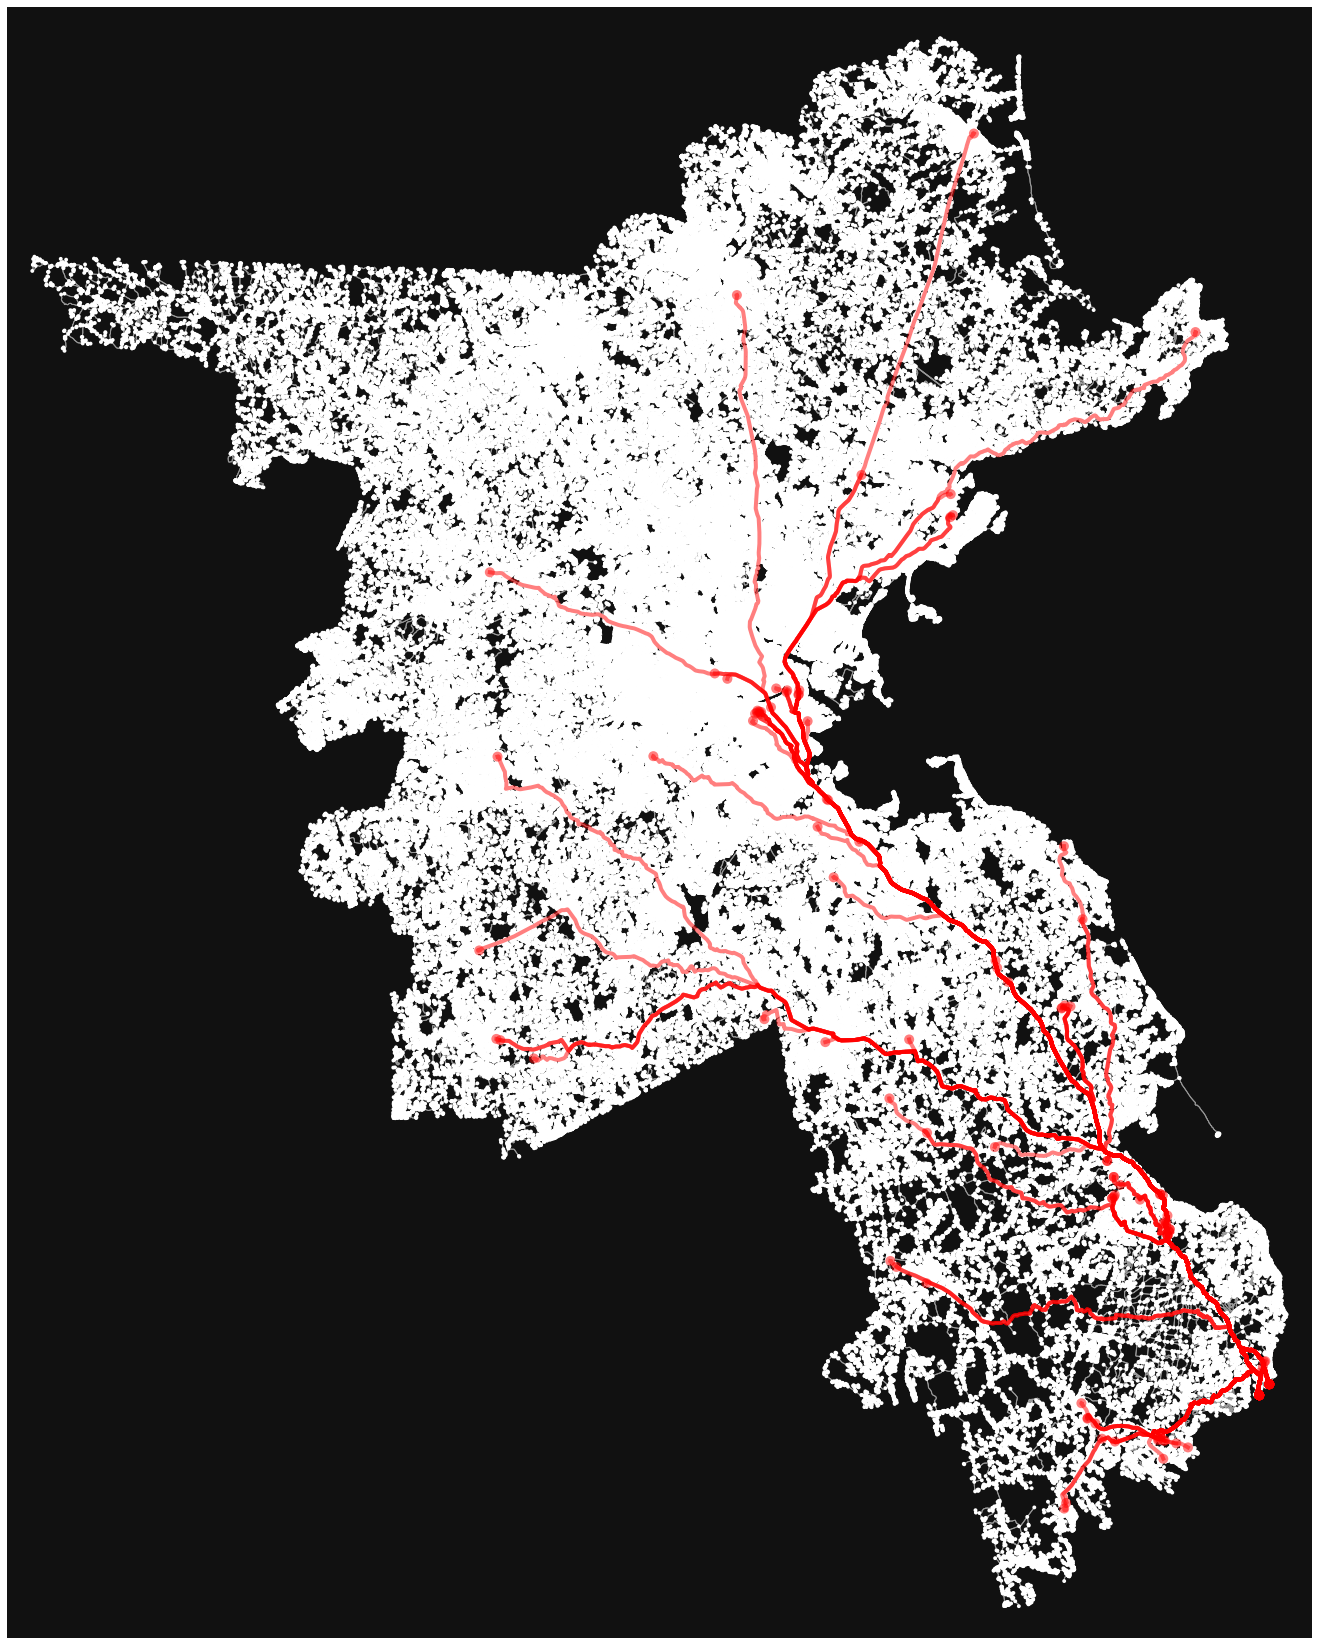

(<Figure size 2160x2160 with 1 Axes>, <AxesSubplot:>)

In [14]:
ox.plot.plot_graph_routes(boston_walk_graph, boston_od_df.network_route.values, figsize=(30,30))

Seems like it work. For the real application, we will not need the route, but simply the distance. To parallelize this function we need to tweak the OSMnx implementation:

In [16]:
def _single_shortest_path_distance(G, orig, dest, weight):
    """
    Get shortest path distance from an origin node to a destination node.
    This function is a convenience wrapper around networkx.shortest_path, with
    exception handling for unsolvable paths.
    Parameters
    ----------
    G : networkx.MultiDiGraph
        input graph
    orig : int
        origin node ID
    dest : int
        destination node ID
    weight : string
        edge attribute to minimize when solving shortest path
    Returns
    -------
    dist : float
        shortest (weighted) distance between origin and destination nodes
    """
    try:
        return nx.shortest_path_length(G, orig, dest, weight=weight) #change function here from G. Boeing's repo
    except nx.exception.NetworkXNoPath:
        return None


def shortest_path_distance(G, orig, dest, weight="length", cpus=1):
    """
    Get shortest path distance from origin node(s) to destination node(s).
    If `orig` and `dest` are single node IDs, this will return a list of the
    nodes constituting the shortest path between them.  If `orig` and `dest`
    are lists of node IDs, this will return a list of lists of the nodes
    constituting the shortest path between each origin-destination pair. If a
    path cannot be solved, this will return None for that path. You can
    parallelize solving multiple paths with the `cpus` parameter, but be
    careful to not exceed your available RAM.
    Parameters
    ----------
    G : networkx.MultiDiGraph
        input graph
    orig : int or list
        origin node ID, or a list of origin node IDs
    dest : int or list
        destination node ID, or a list of destination node IDs
    weight : string
        edge attribute to minimize when solving shortest path
    cpus : int
        how many CPU cores to use; if None, use all available
    Returns
    -------
    path : list
        list of node IDs constituting the shortest path, or, if orig and dest
        are lists, then a list of path lists
    """
    if not (hasattr(orig, "__iter__") or hasattr(dest, "__iter__")):
        # if neither orig nor dest is iterable, just return the shortest path
        return _single_shortest_path_distance(G, orig, dest, weight)

    elif hasattr(orig, "__iter__") and hasattr(dest, "__iter__"):
        # if both orig and dest are iterables ensure they have same lengths
        if len(orig) != len(dest):  # pragma: no cover
            raise ValueError("orig and dest must contain same number of elements")

        if cpus is None:
            cpus = mp.cpu_count()
        cpus = min(cpus, mp.cpu_count())

        if cpus == 1:
            # if single-threading, calculate each shortest path one at a time
            paths = [_single_shortest_path_distance(G, o, d, weight) for o, d in zip(orig, dest)]
        else:
            # if multi-threading, calculate shortest paths in parallel
            args = ((G, o, d, weight) for o, d in zip(orig, dest))
            pool = mp.Pool(cpus)
            sma = pool.starmap_async(_single_shortest_path_distance, args)
            paths = sma.get()
            pool.close()
            pool.join()

        return paths

    else:
        # if only one of orig or dest is iterable and the other is not
        raise ValueError("orig and dest must either both be iterable or neither must be iterable")

In [17]:
boston_od_df['network_distance'] = shortest_path_distance(boston_walk_graph,
                                                          orig=boston_od_df.origin_osmid, dest=boston_od_df.dest_osmid)

In [18]:
boston_od_df

,census_block_group,id,date_range_start,date_range_end,safegraph_place_id,latitude,longitude,intptlon,intptlat,poi_cbg,est_visitor,distance,state,top_category,origin_osmid,dest_osmid,network_route,network_distance
0,2.500100e+11,207335,9/2/19 05:00,9/9/19 05:00,sg:ce11db7e2fe34ac0929d4f357f517706,41.956274,-70.664559,-70.512049,41.770210,2.502350e+11,106.666667,24239.55247,ma,Restaurants and Other Eating Places,72323864,8417458566,"[72323864, 8136334773, 72243530, 72505627, 807...",22077.459
1,2.500100e+11,456782,9/9/19 05:00,9/16/19 05:00,sg:c449cc9f5cd445deadf02bfe03396b2a,42.236044,-70.768497,-70.512049,41.770210,2.502350e+11,81.920000,55965.14288,ma,Other Amusement and Recreation Industries,72323864,6880721828,"[72323864, 8136334773, 72243530, 72505627, 807...",59606.524
2,2.500100e+11,748211,9/16/19 05:00,9/23/19 05:00,sg:e8e7e9f5204f45cb8d1ab353a94f1b4a,41.788276,-70.750110,-70.512049,41.770210,2.502350e+11,110.702703,19841.97195,ma,Gasoline Stations,72323864,7809363894,"[72323864, 8136334773, 72243530, 72505627, 807...",23715.350
3,2.500100e+11,539378,9/16/19 05:00,9/23/19 05:00,sg:1795a3a508eb4b599c080c0b7114aa7c,42.080822,-70.937099,-70.512049,41.770210,2.502350e+11,110.702703,49289.45174,ma,Restaurants and Other Eating Places,72323864,5436194838,"[72323864, 8136334773, 72243530, 72505627, 807...",51618.601
4,2.500100e+11,986779,9/23/19 05:00,9/30/19 05:00,sg:e30a618073494f5a847a48cb982e8fd3,41.954507,-70.714388,-70.512049,41.770210,2.502350e+11,102.400000,26471.27337,ma,Restaurants and Other Eating Places,72323864,970365944,"[72323864, 8136334773, 72243530, 72505627, 807...",26211.148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2.500100e+11,106321,9/2/19 05:00,9/9/19 05:00,sg:63e9fd5cda7648d9abf29c60f323866d,41.897718,-70.951001,-70.489784,41.760315,2.502350e+11,73.230769,41155.49921,ma,Restaurants and Other Eating Places,71952777,5475519528,"[71952777, 72303548, 8257527270, 8257527251, 7...",43874.623
96,2.500100e+11,747550,9/16/19 05:00,9/23/19 05:00,sg:e807cf3461444a5e954342a34c46a1ec,41.758087,-70.666694,-70.489784,41.760315,2.502350e+11,86.545455,14676.09350,ma,Other Amusement and Recreation Industries,71952777,5475534490,"[71952777, 72303548, 8257527270, 8257527251, 7...",16999.923
97,2.500100e+11,757369,9/16/19 05:00,9/23/19 05:00,sg:f21a9d43500c4b12bc195b77caa997ce,41.930511,-70.657772,-70.489784,41.760315,2.502350e+11,86.545455,23490.14658,ma,Restaurants and Other Eating Places,71952777,4047472841,"[71952777, 72303548, 8257527270, 8257527251, 7...",18400.065
98,2.500100e+11,451727,9/9/19 05:00,9/16/19 05:00,sg:bf0b9719047e449bbcbfa8d79e135dc9,41.758129,-70.660567,-70.489784,41.760315,2.502350e+11,75.157895,14167.87299,ma,Restaurants and Other Eating Places,71952777,5475447850,"[71952777, 72303548, 8257527270, 8257527251, 7...",17433.741


## Checking whether this is working

- How do we know this is working? Ideas for checking the procedure
- Plotting against the original straight-line distance is weird

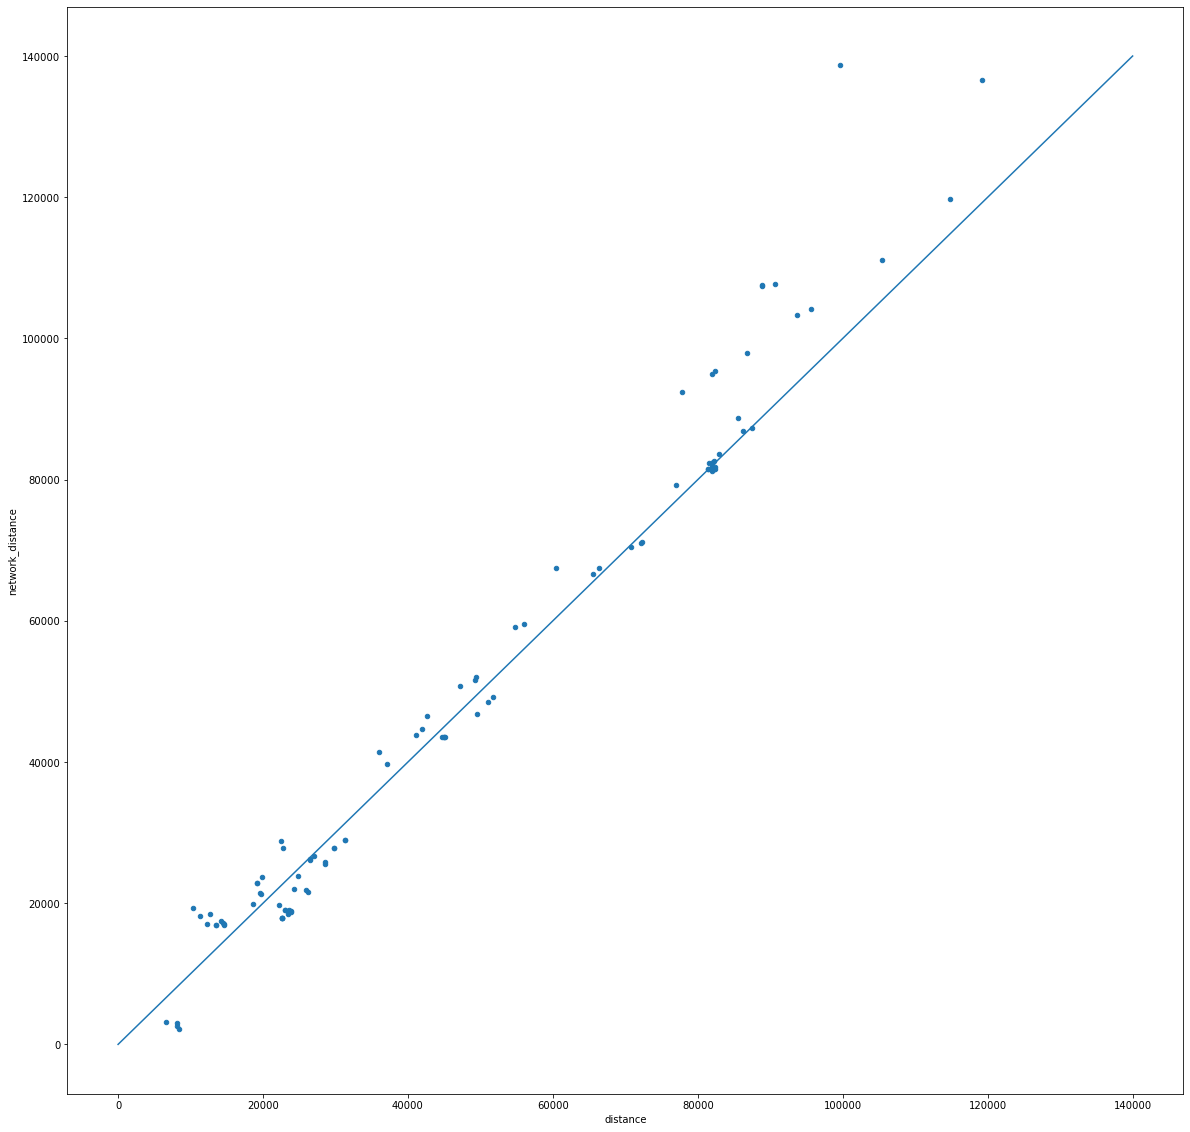

In [21]:
ax = boston_od_df.plot.scatter(x='distance', y='network_distance', figsize=(20,20))
ax.plot([0, 140000], [0, 140000])

Where was the centroid we considered and where did it end up? Use the fact that the first route was constant:

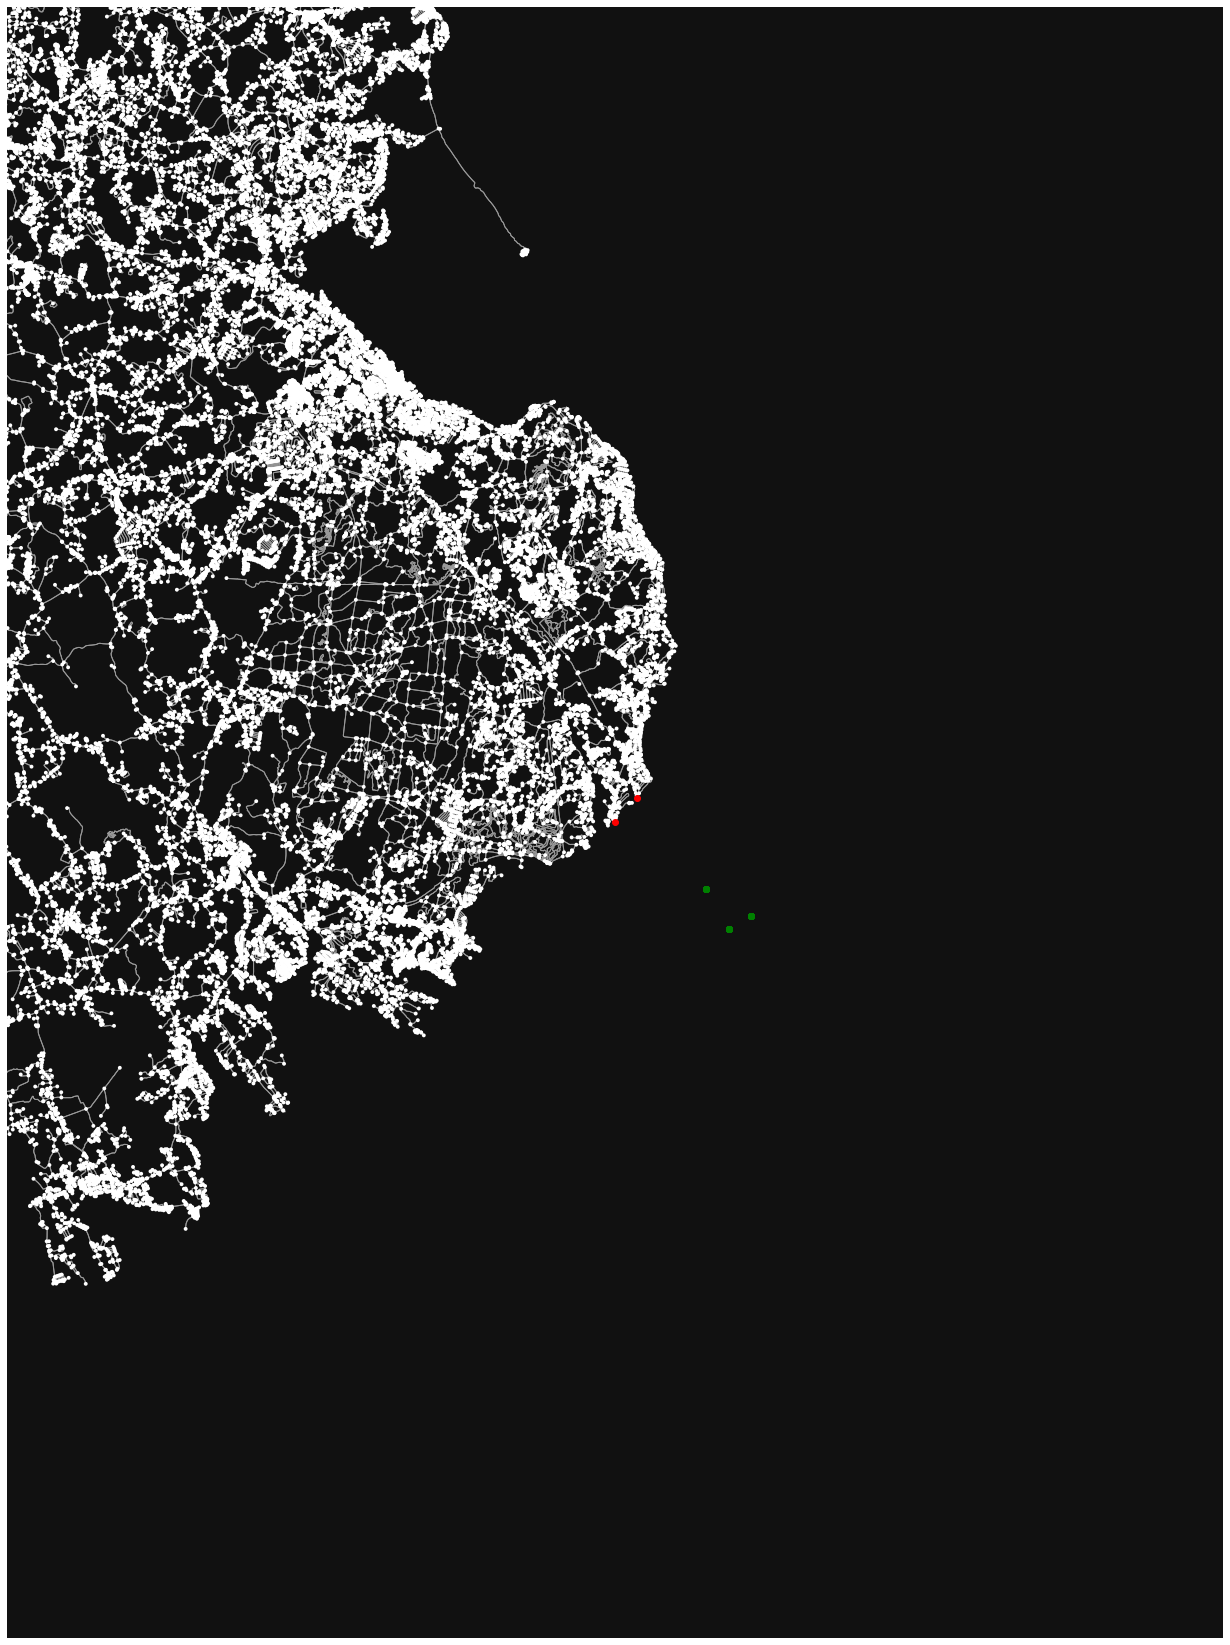

In [33]:
import matplotlib.pyplot as plt

center = boston_od_df.origin_osmid[0]
center_x = nx.get_node_attributes(boston_walk_graph,'x')[center]
center_y = nx.get_node_attributes(boston_walk_graph,'y')[center]
bbox = center_y + 0.3, center_y - 0.3, center_x + 0.3, center_x - 0.3

origins = list(set(boston_od_df.origin_osmid.values))
center_x = [nx.get_node_attributes(boston_walk_graph,'x')[center] for center in origins]
center_y = [nx.get_node_attributes(boston_walk_graph,'y')[center] for center in origins]

fig, ax = ox.plot_graph(boston_walk_graph, close=False, show=False, figsize=(30,30), bbox=bbox)
ax.scatter(boston_od_df.intptlon.values, boston_od_df.intptlat.values, c='green')
ax.scatter(center_x, center_y, c='red')

This may be off because of the centroids! They are far removed from Boston (Google Maps also shows that, they are in Cape Cod). Is that always going to be the case? In the networks, we really need the census block to be part of the network.

## simple fix: add the straight line distance from point to node

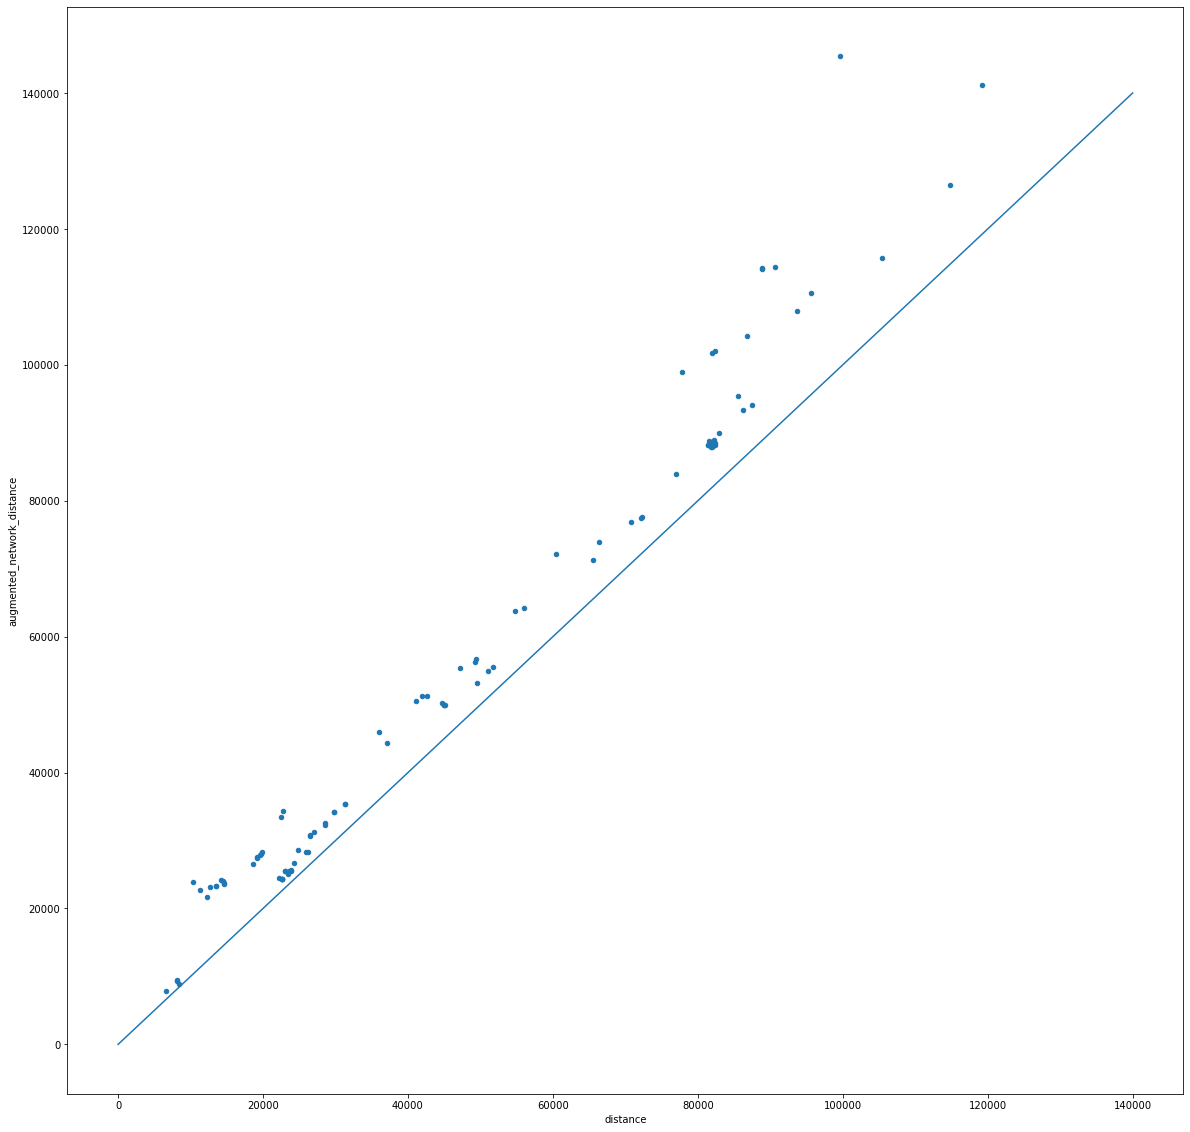

In [38]:
boston_od_df['augmented_network_distance'] = boston_od_df['network_distance'] + boston_od_df['origin_node_dist'] + boston_od_df['dest_node_dist']
ax = boston_od_df.plot.scatter(x='distance', y='augmented_network_distance', figsize=(20,20))
ax.plot([0, 140000], [0, 140000])